In [37]:
import os
file_path = '/content/drive/MyDrive/Zeru Finance/user-wallet-transactions.json'

In [38]:
import pandas as pd
import json

with open(file_path) as f:
  data = json.load(f)

In [39]:
df = pd.DataFrame(data)
print(df.head())

                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...   

 

In [40]:
print(df.columns)
print(df.info())

Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   _id          100000 non-null  object
 1   userWallet   100000 non-null  object
 2   network      100000 non-null  object
 3   protocol     100000 non-null  object
 4   txHash       100000 non-null  object
 5   logId        100000 non-null  object
 6   timestamp    100000 non-null  int64 
 7   blockNumber  100000 non-null  int64 
 8   action       100000 non-null  object
 9   actionData   100000 non-null  object
 10  __v          100000 non-null  int64 
 11  createdAt    100000 non-null  object
 12  updatedAt    100000 non-null  object
dtypes: int64(3), object(10)
memory usage: 9.9+ MB
None


In [41]:
print(df['actionData'].head())

0    {'type': 'Deposit', 'amount': '2000000000', 'a...
1    {'type': 'Deposit', 'amount': '145000000000000...
2    {'type': 'Deposit', 'amount': '100000000000000...
3    {'type': 'Deposit', 'amount': '400000000000000...
4    {'type': 'RedeemUnderlying', 'amount': '501548...
Name: actionData, dtype: object


In [42]:
print(type(df['actionData'][0]))
print(df['actionData'][0])


<class 'dict'>
{'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}


In [43]:
def extract_amount(row):
    data = row
    amount_wei = float(data.get('amount', 0))
    amount_eth = amount_wei / 1e18
    return amount_eth

df['amount'] = df['actionData'].apply(extract_amount)

In [44]:
print(df[['userWallet', 'action', 'amount']].head())


                                   userWallet            action        amount
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit  2.000000e-09
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit  1.450000e+02
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  1.000000e-03
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  4.000000e-03
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying  5.015480e-13


In [45]:
def engineer_features(df):
  grouped = df.groupby(['userWallet','action']).agg({'amount': ['sum','count']}).reset_index()
  grouped.columns = ['userWallet', 'action', 'total_amount', 'count']
  pivot = grouped.pivot(index='userWallet', columns='action', values=['total_amount','count']).fillna(0)
  pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
  pivot.reset_index(inplace=True)
  pivot['repay_to_borrow_ratio'] = pivot.apply(lambda x: x['total_amount_repay']/x['total_amount_borrow'] if x['total_amount_borrow']>0 else 0, axis =1)
  pivot['liquidation_flag'] = pivot.get('count_liquidationcall', 0).apply(lambda x: 1 if x > 0 else 0)
  return pivot
features_df = engineer_features(df)
features_df.head()

,userWallet,total_amount_borrow,total_amount_deposit,total_amount_liquidationcall,total_amount_redeemunderlying,total_amount_repay,count_borrow,count_deposit,count_liquidationcall,count_redeemunderlying,count_repay,repay_to_borrow_ratio,liquidation_flag
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,0.0,2.000000e-09,0.0,0.000000,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0
1,0x000000000051d07a4fb3bd10121a343d85818da6,0.0,1.450000e+02,0.0,0.000000,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,0.0,5.000000e-03,0.0,0.000000,0.000000e+00,0.0,2.0,0.0,0.0,0.0,0.000000e+00,0
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.0,0.000000e+00,0.0,4.835297,0.000000e+00,0.0,0.0,0.0,17.0,0.0,0.000000e+00,0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,39460.0,9.459366e+04,0.0,39465.558797,7.002457e-08,15.0,250.0,0.0,130.0,4.0,1.774571e-12,0


In [46]:
import numpy as np

def calculate_score(features_df):
  features_df['repay_to_borrow_ratio_norm'] = features_df['repay_to_borrow_ratio'] / features_df['repay_to_borrow_ratio'].max()
  features_df['deposit_amount_norm'] = features_df.get('total_amount_deposit', 0) / features_df.get('total_amount_deposit', 0).max()
  alpha = 0.5
  beta = 0.4
  gamma = 0.1
  features_df['raw_score'] = (alpha * features_df['repay_to_borrow_ratio_norm'] +
                                beta * features_df['deposit_amount_norm'] -
                                gamma * features_df['liquidation_flag'])
  features_df['credit_score'] = (features_df['raw_score'] - features_df['raw_score'].min()) / \
                                  (features_df['raw_score'].max() - features_df['raw_score'].min()) * 1000
  features_df['credit_score'] = features_df['credit_score'].clip(0, 1000)
  return features_df[['userWallet', 'credit_score']]

In [47]:
scored_df = calculate_score(features_df)


In [48]:
scored_df.head()

,userWallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,133.534617
1,0x000000000051d07a4fb3bd10121a343d85818da6,133.536082
2,0x000000000096026fb41fc39f9875d164bd82e2dc,133.534617
3,0x0000000000e189dd664b9ab08a33c4839953852c,133.534617
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,134.490875


In [49]:
print("Max repay_to_borrow_ratio:", features_df['repay_to_borrow_ratio'].max())
print("Max total_amount_deposit:", features_df.get('total_amount_deposit', pd.Series([0])).max())


Max repay_to_borrow_ratio: 2.0112915767204025
Max total_amount_deposit: 52837322.65103469


In [50]:
scored_df.head(10)

,userWallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,133.534617
1,0x000000000051d07a4fb3bd10121a343d85818da6,133.536082
2,0x000000000096026fb41fc39f9875d164bd82e2dc,133.534617
3,0x0000000000e189dd664b9ab08a33c4839953852c,133.534617
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,134.490875
5,0x000000000a38444e0a6e37d3b630d7e855a7cb13,465.851521
6,0x000000003853fcedcd0355fec98ca3192833f00b,133.534617
7,0x000000003ce0cf2c037493b1dc087204bd7f713e,137.601409
8,0x000000007858e6f2668e1e06111cfa24403a5466,133.534618
9,0x00000001a0f57e850c9db68b4a9bc34677437c5c,133.534617


# Analysis

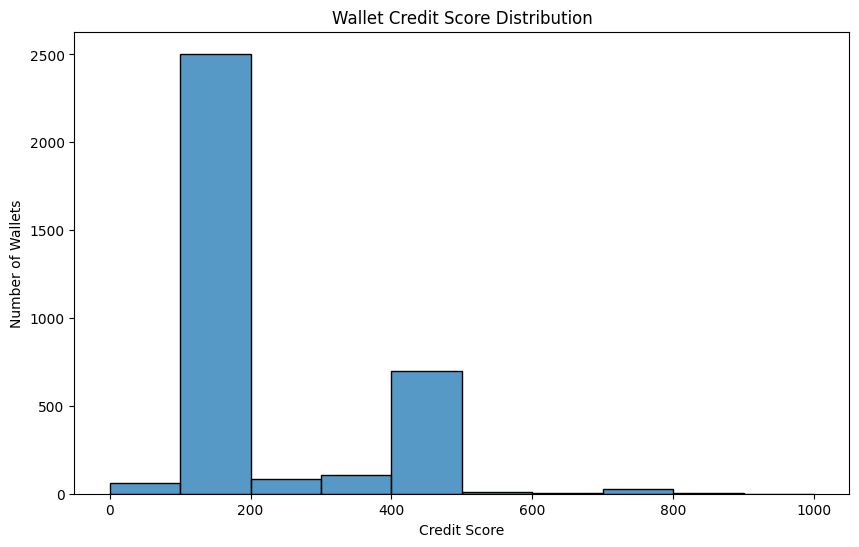

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(scored_df['credit_score'], bins=10)
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.savefig('score_distribution.png')
plt.show()

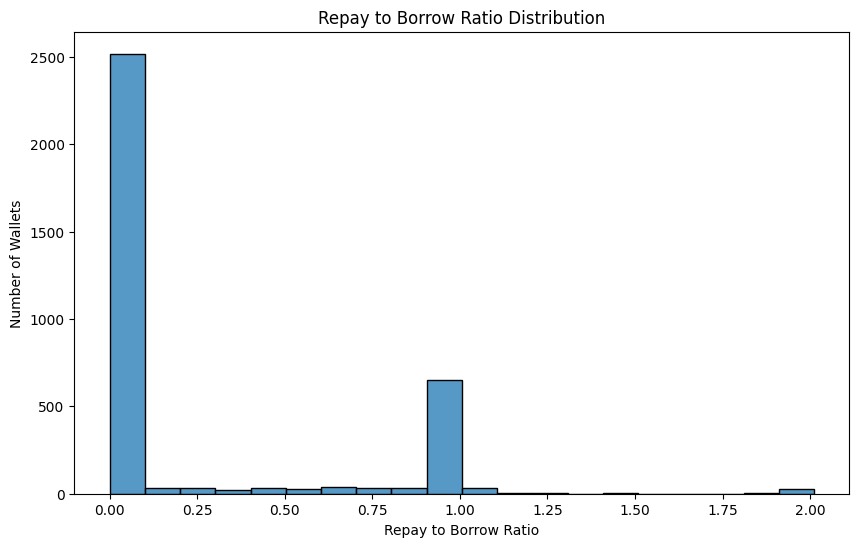

In [52]:
plt.figure(figsize=(10,6))
sns.histplot(features_df['repay_to_borrow_ratio'], bins=20)
plt.title('Repay to Borrow Ratio Distribution')
plt.xlabel('Repay to Borrow Ratio')
plt.ylabel('Number of Wallets')
plt.savefig('repay_to_borrow_ratio_distribution.png')
plt.show()


In [33]:
top10 = scored_df.sort_values(by='credit_score', ascending=False).head(10)
print(top10)


                                      userWallet  credit_score
137   0x0034baeeb160a5f1032b6d124d3e87cc94d74e62   1000.000000
54    0x000f7f22bfc28d940d4b68e13213ab17cf107790    878.270155
1715  0x02e4ac7c366cf7320bc78b816b162b26d605a4bd    801.208323
1058  0x01b92f893b1c302bcf1945fd4edf10df99b4f181    799.768291
2846  0x04efc3225aa96a0fcb977bfbada6712f99310545    798.578830
1544  0x0292c117e0fc26212b22c5843b9755e7b676c6c0    798.523367
1389  0x025297ca7459dd67dbfd8443d9b5f321e89fad83    798.032441
75    0x0019971fb18fbfc9108d90eb2cdd4d5a0a897eee    797.871564
1502  0x028062ffc2a94ca94e464240142c956d10fa449d    797.841964
2079  0x037e908997841df68afb48eb1c9a6e441310abf5    797.579879


In [53]:
def score_category(score):
    if score < 400:
        return 'Low'
    elif score < 700:
        return 'Mid'
    else:
        return 'Top'

scored_df['score_segment'] = scored_df['credit_score'].apply(score_category)


/tmp/ipython-input-53-4219584221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scored_df['score_segment'] = scored_df['credit_score'].apply(score_category)


/tmp/ipython-input-54-788860101.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score_segment', data=scored_df, palette='viridis')


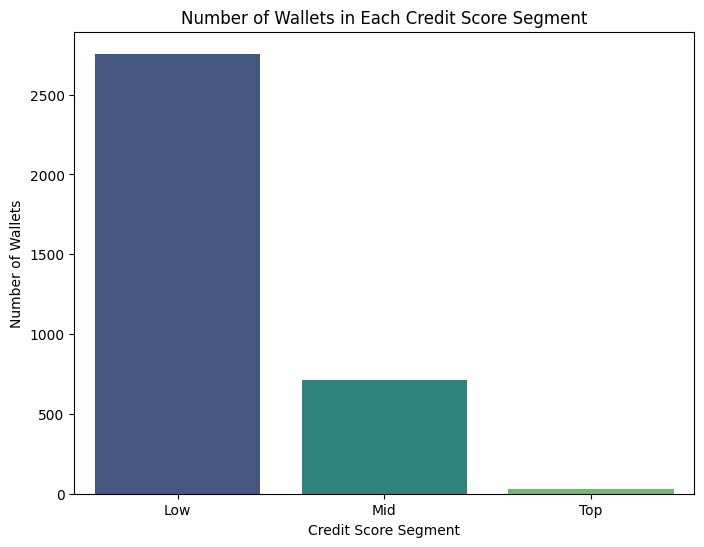

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x='score_segment', data=scored_df, palette='viridis')
plt.title('Number of Wallets in Each Credit Score Segment')
plt.xlabel('Credit Score Segment')
plt.ylabel('Number of Wallets')
plt.savefig('credit_score_segments.png')
plt.show()


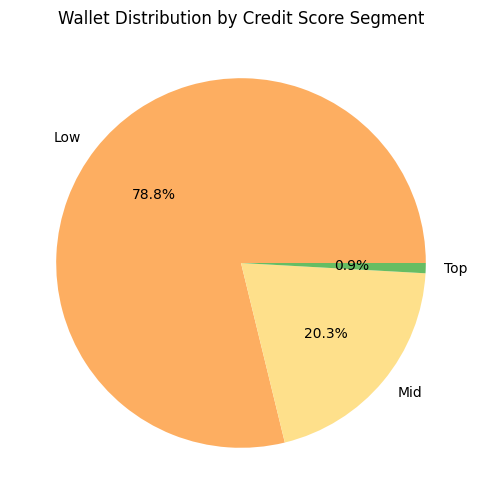

In [55]:
plt.figure(figsize=(6,6))
scored_df['score_segment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#fdae61','#fee08b','#66bd63'])
plt.title('Wallet Distribution by Credit Score Segment')
plt.ylabel('')
plt.savefig('credit_score_segments_pie.png')
plt.show()


In [56]:
import json

output_records = scored_df.to_dict(orient='records')
output_path = '/content/drive/MyDrive/Zeru Finance/wallet_credit_scores.json'

with open(output_path, 'w') as f:
    json.dump(output_records, f, indent=4)
